In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [ ]:
classFiltSeurat = readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/marmoset_snrna_all_soupX_fil_batch1_0619.rds')
#http://localhost:1818/notebooks/spa_seurat/cla/renew_sndata_0619_mouse_mamoset/20230619.cla_snrna/mamoset/2文库过滤.ipynb
# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

dataDir='/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/'
saveRDS(classFiltSeurat,paste0(dataDir, "/marmoset_snrna_all_soupX_fil_batch1_0619_SCT.rds"))





In [ ]:
#!/bin/bash
#SBATCH -e /home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/err
#SBATCH -o /home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/out
#SBATCH -J 22222222222222
#SBATCH -p pro
#SBATCH --mem 500000
#SBATCH -n 2

Rscript /home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/sct.R




In [2]:
readDir='/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/'
file_name='marmoset_snrna_all_soupX_fil_batch1_0619_SCT.rds'
seurat=readRDS(paste0(readDir,file_name))


In [3]:
classFiltSeurat=seurat
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all", 
    "/屏状核-建库清单.xlsx"
))


libMetaTb=libMetaTb[,c('样本名称','分析样本名称','oligo文库名称')]
colnames(libMetaTb)=c('sample','sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]*')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)
libMetaTb1=libMetaTb

libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla", 
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('jobid','tissue','sampleID')]
colnames(libMetaTb)=c('sample','sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)
libMetaTb2=libMetaTb

libMetaTb=rbind(libMetaTb1,libMetaTb2)


ref=classFiltSeurat@meta.data[,'group',drop=F]
ref$cell=rownames(ref)
libMetaTb$group=libMetaTb$libId
ref=left_join(ref,libMetaTb)
ref=ref[!duplicated(ref),]

classFiltSeurat=AddMetaData(classFiltSeurat,col.name = 'sample',ref$sample)
classFiltSeurat@meta.data[grep('2194',classFiltSeurat@meta.data$group),]$sample='MT29-051'

classFiltSeurat$batch=classFiltSeurat$sample


sample,sampleId,libId
<chr>,<chr>,<chr>
MS-cla-001,MS-cla-001,2191-1
MS-cla-001,MS-cla-001,2191-2
MS-cla-001,MS-cla-001,2191-3
MS-cla-001,MS-cla-001,2191-4
MS-cla-001,MS-cla-001,2191-5
MS-cla-001,MS-cla-001,2191-6


New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sample,sampleId,libId
<chr>,<chr>,<chr>
MQC286R-cla,Cla-rostral,6103-1
MQC286R-cla,Cla-rostral,6103-2
MQC286R-cla,Cla-rostral,6103-3
MQC286R-cla,Cla-rostral,6103-4
MQC286R-cla,Cla-rostral,6103-5
MQC286R-cla,Cla-rostral,6103-6


Joining, by = "group"


In [4]:
table(classFiltSeurat$sample)


MT23R-001  MT29-043  MT29-051  MT30-008 
    28085     58444     24144     67527 

In [5]:
sum(table(classFiltSeurat$sample))

[1] 178200

In [6]:
classFiltSeurat

An object of class Seurat 
63792 features across 178200 samples within 2 assays 
Active assay: SCT (30873 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

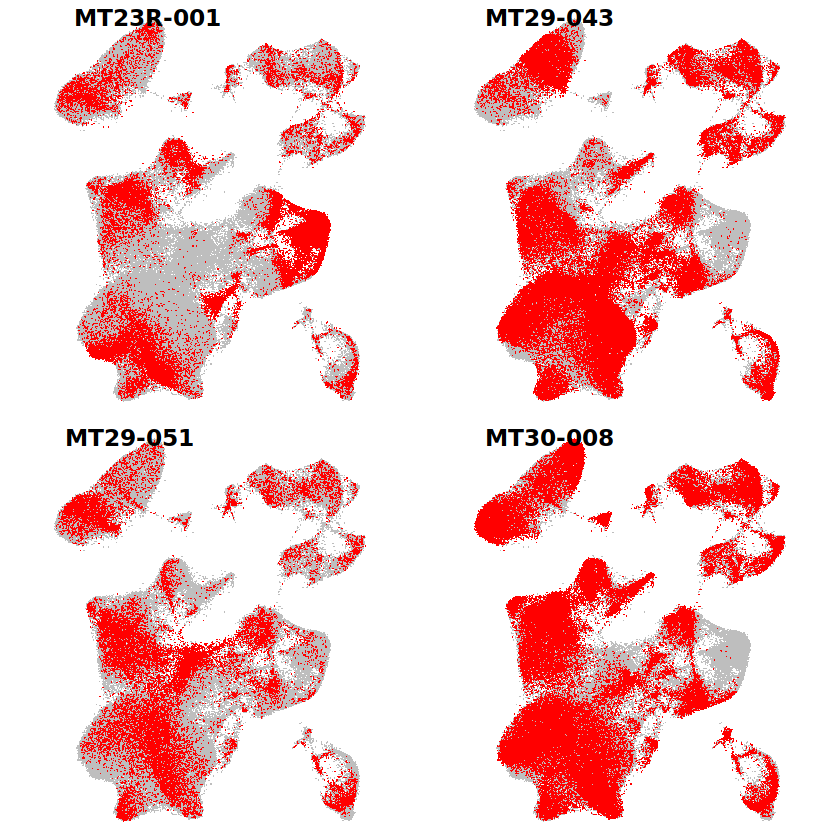

In [7]:
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(classFiltSeurat, highlightBy="sample", showAllPoints=T, size=0.1)
       

In [8]:
seurat=classFiltSeurat

In [9]:
DefaultAssay(classFiltSeurat)

[1] "SCT"

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: DLX6-AS1, ZMYDN10, ALPHA-SMA, PDGFRALPHA, VECAD, CD105, COX4l2, MOTCH3, CS3CR1”


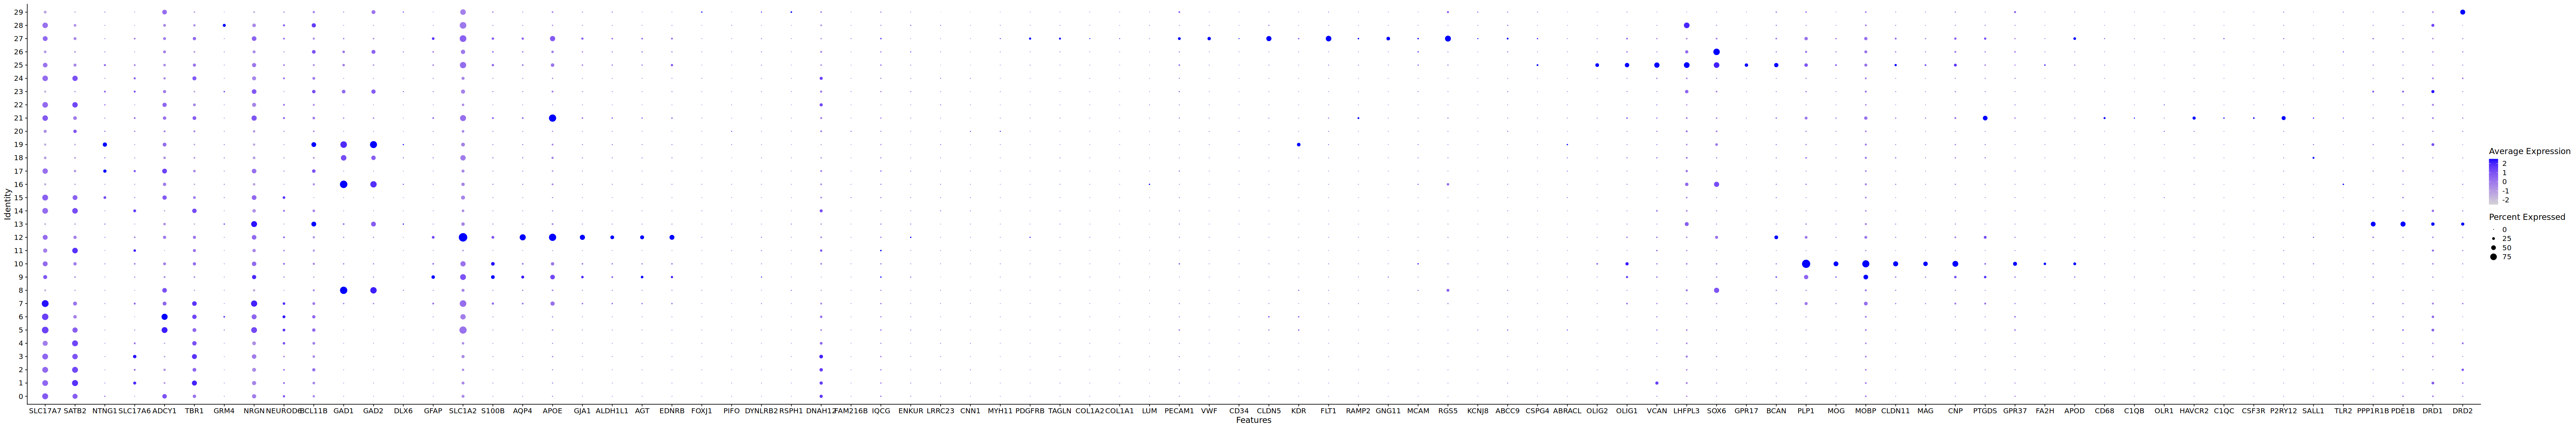

In [10]:

selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2',# Microglia
    'PPP1R1B','BCL11B','PDE1B','DRD1','DRD2'
)



selectMarkers=selectMarkers

selectMarkers=selectMarkers[!duplicated(selectMarkers)]
Idents(classFiltSeurat) = "seurat_clusters"
options(repr.plot.height=10,repr.plot.width=60)
DotPlot(classFiltSeurat, features = selectMarkers)




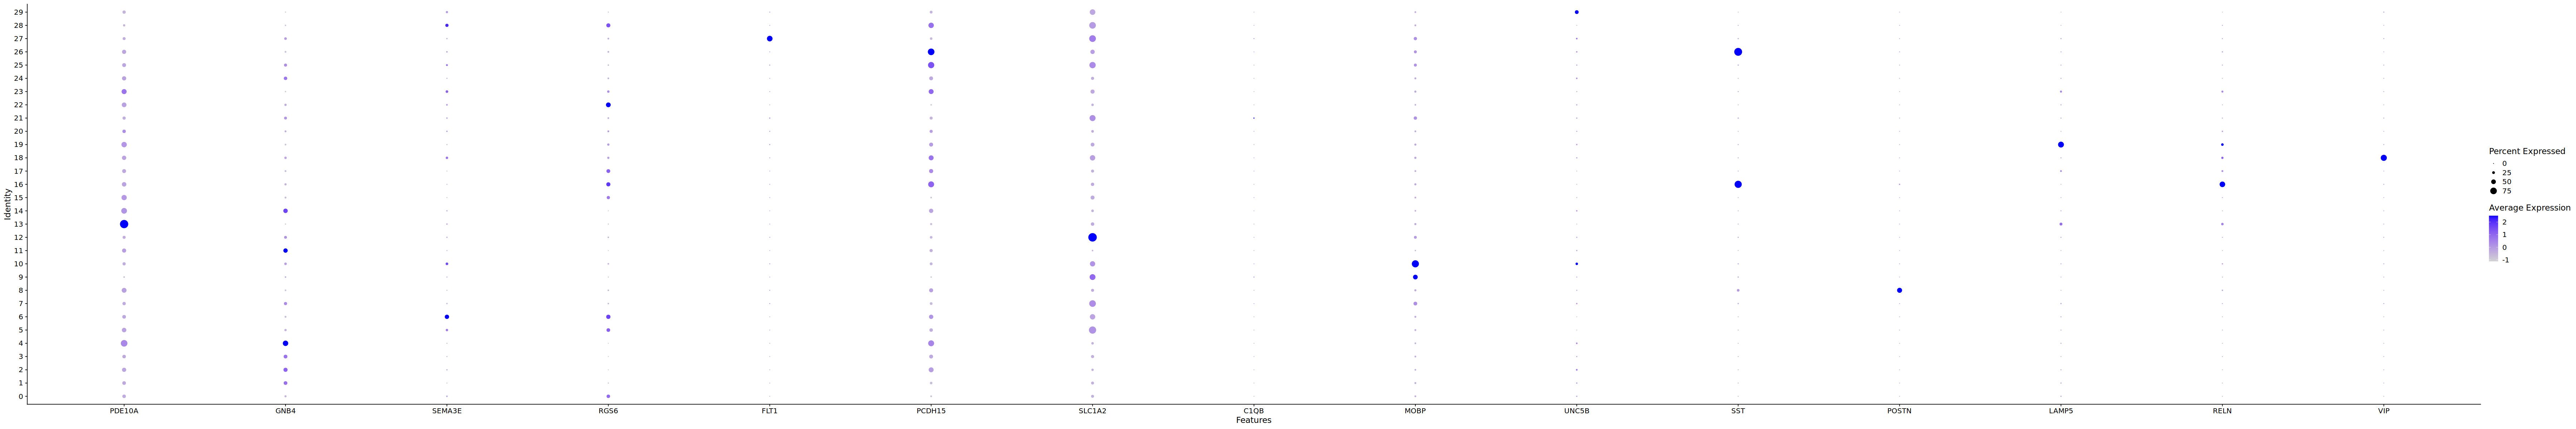

In [14]:

selectMarkers  =c('PDE10A','GNB4','SEMA3E','RGS6',
    'FLT1','PCDH15','SLC1A2','C1QB','MOBP',
                 'UNC5B','SST','POSTN','LAMP5','RELN','VIP'
              )



selectMarkers=selectMarkers

selectMarkers=selectMarkers[!duplicated(selectMarkers)]
Idents(classFiltSeurat) = "seurat_clusters"
options(repr.plot.height=10,repr.plot.width=60)
DotPlot(classFiltSeurat, features = selectMarkers)


In [11]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,1,2,3,4,5,6,11,14,15,17,22),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(8,16,18,19),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(12),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(10),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(27),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(25),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(13),]$class='MSN'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(21),]$class='Microglia'



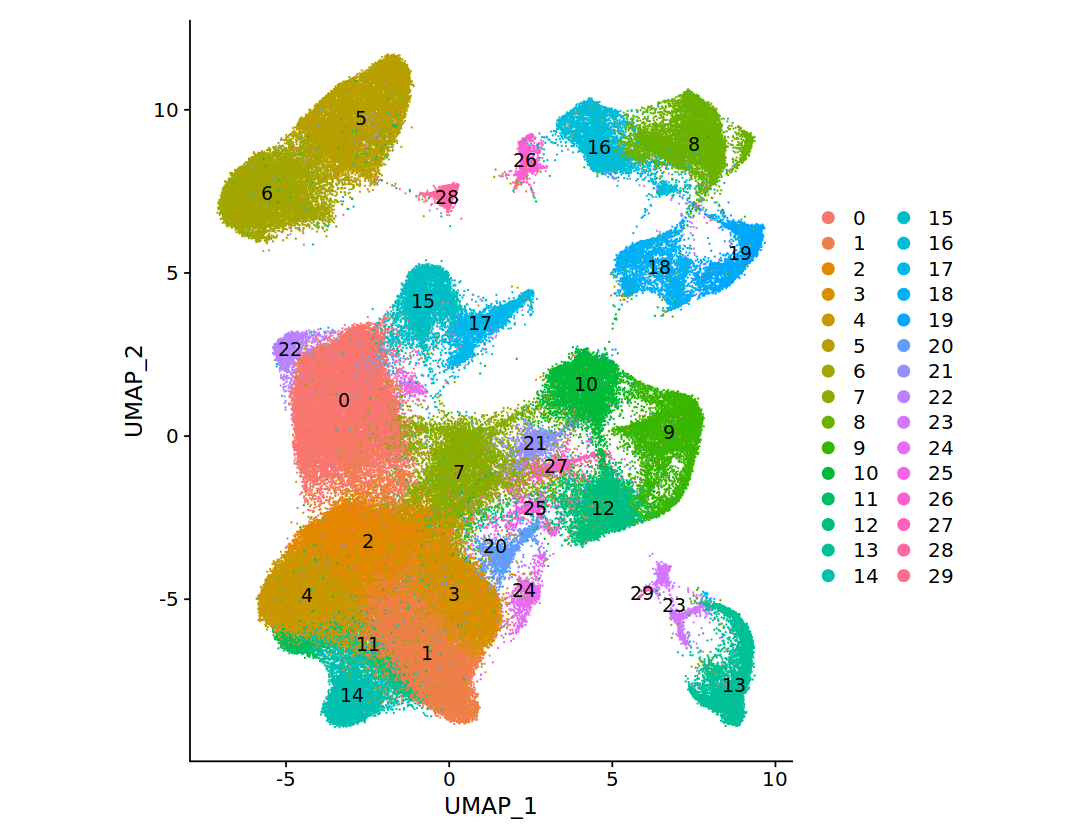

In [12]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()


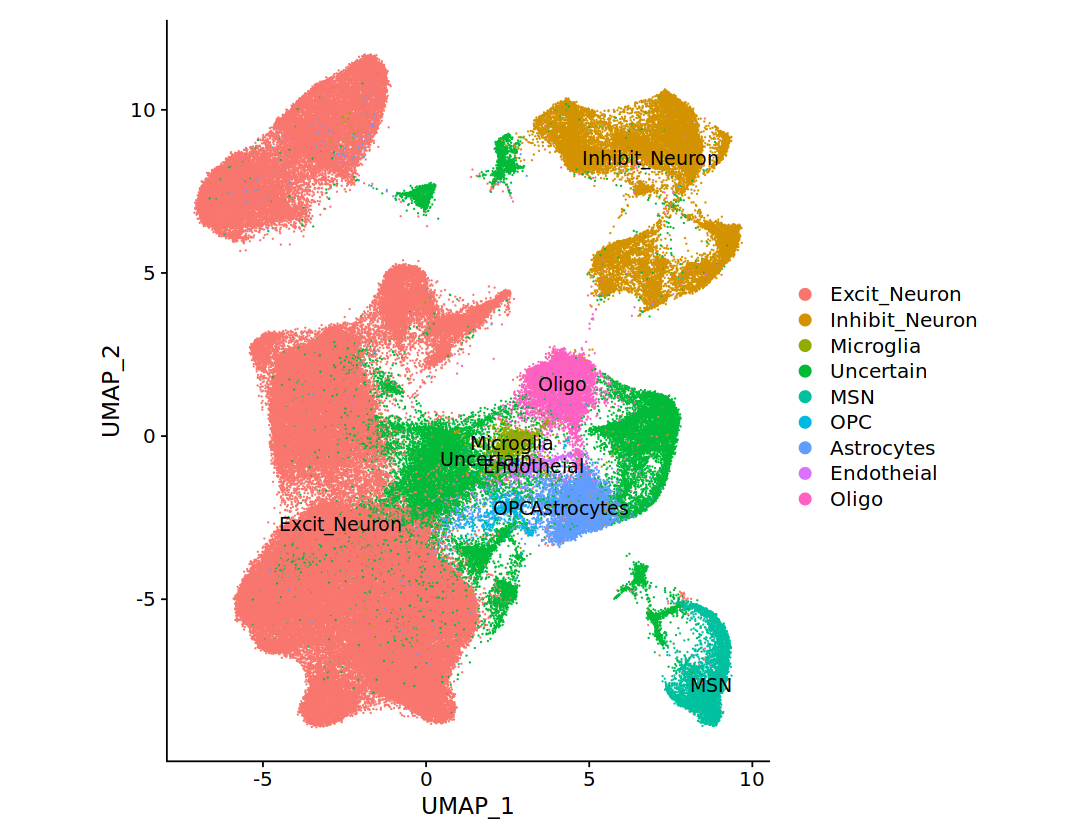

In [19]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [20]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	31734 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          4676            748           5000           5000           1284 
           MSN          Oligo            OPC      Uncertain 
          4437           4786            803           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          4676            748           5000           5000           1284 
           MSN          Oligo            OPC      Uncertain 
          4437           4786            803           5000 

In [21]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))


Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster MSN

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            33             19              1             37             11 
           MSN          Oligo            OPC      Uncertain 
            84             19             16              9 

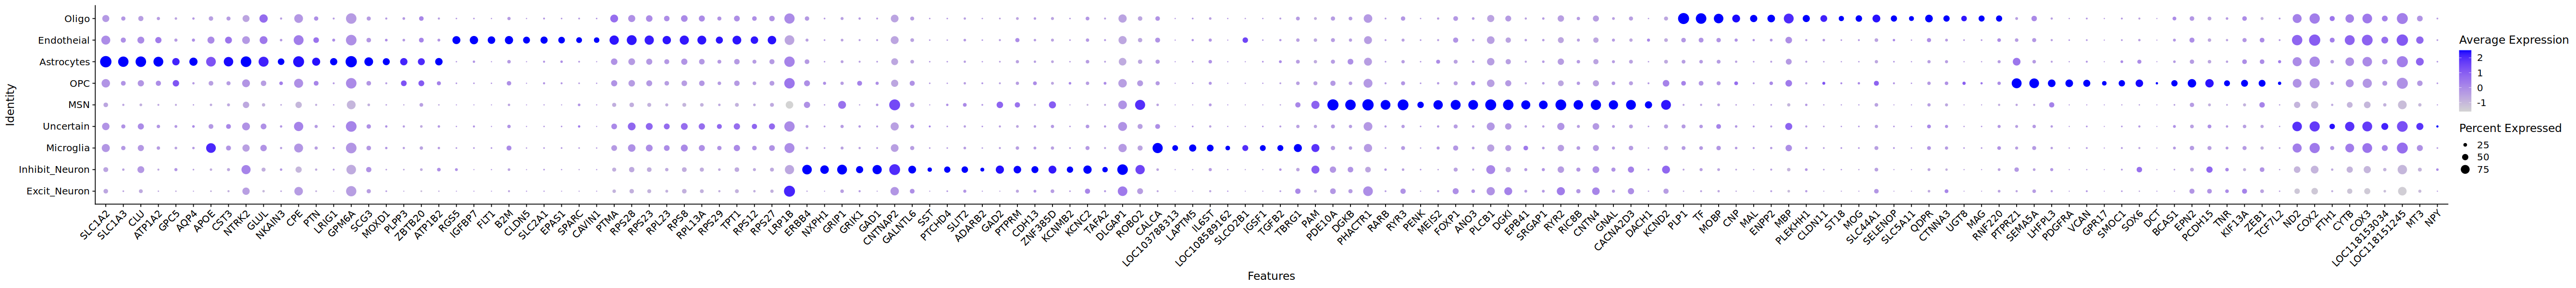

In [22]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

 num [1:8, 1:9] 4513 78 79 63 98 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:9] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


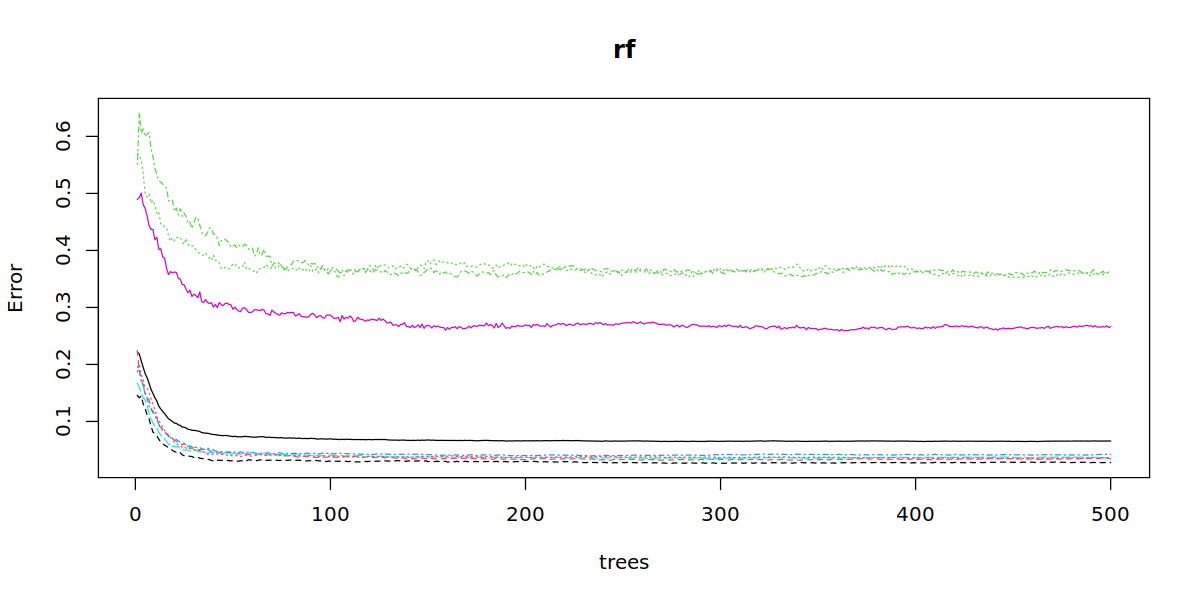

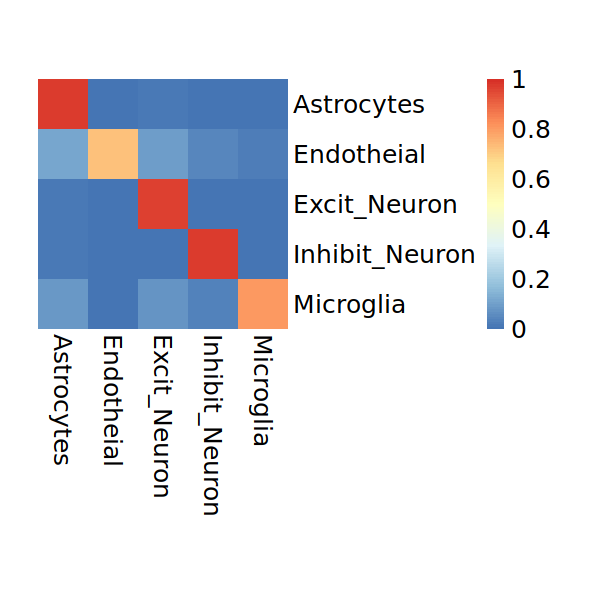

In [25]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:5, 1:5], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:178200, 1:8] 0 0 0 0.012 0.128 0 0.024 0.062 0.008 0.008 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:178200] "6708-1_CELL197_N2" "6708-1_CELL2028_N1" "6708-1_CELL1614_N1" "6708-1_CELL2834_N1" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId,maxPredClassScore,maxPredClass
<chr>,<dbl>,<chr>
6708-1_CELL197_N2,0.990,Excit_Neuron
6708-1_CELL2028_N1,0.978,Excit_Neuron
6708-1_CELL1614_N1,0.946,Inhibit_Neuron
6708-1_CELL2834_N1,0.932,Excit_Neuron
6708-1_CELL230_N2,0.316,Microglia
6708-1_CELL3602_N1,0.972,Excit_Neuron


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1620  0.6920  0.8800  0.7976  0.9620  1.0000 

[1] TRUE

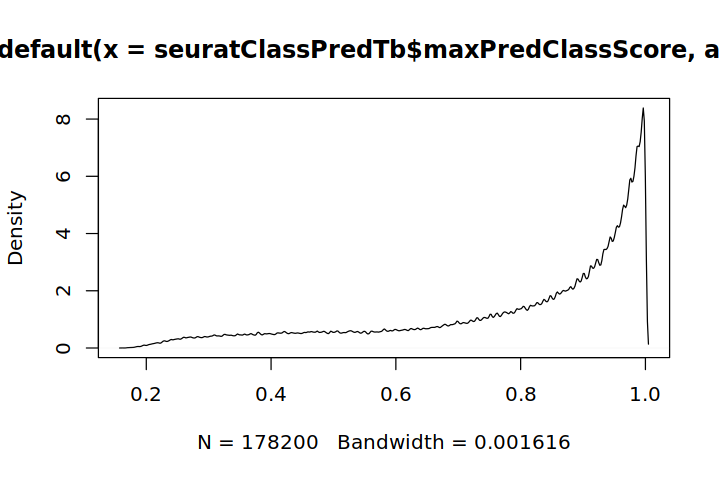

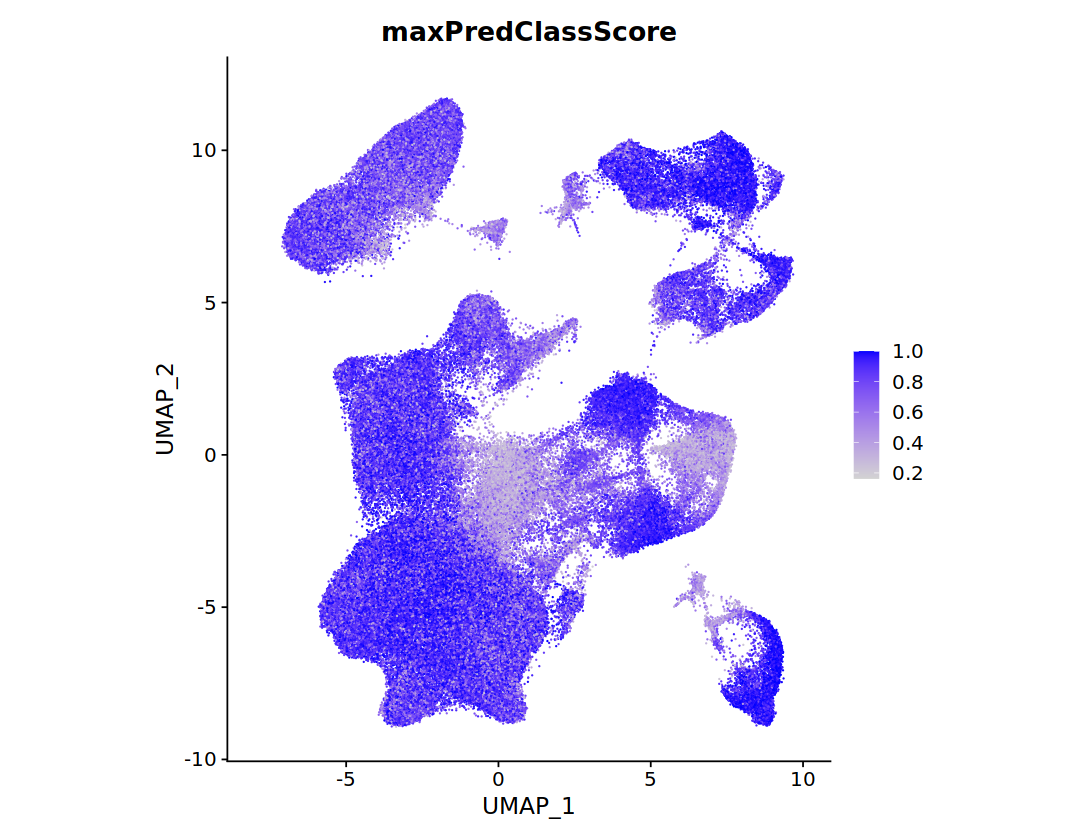

In [26]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [27]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)


Filt cell ratio: 0.634859708193041



In [28]:
classFiltSeurat

An object of class Seurat 
63792 features across 113132 samples within 2 assays 
Active assay: SCT (30873 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [29]:
#EXIN按照nfeature800过滤
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat=subset(classFiltSeurat,cells = fil_cell)

classFiltSeurat

An object of class Seurat 
63792 features across 110935 samples within 2 assays 
Active assay: SCT (30873 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [30]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_240115/marmoset_snrna_all_soupX_fil300_800_anno_SCT_RFfil_240116.rds')



In [31]:
table(classFiltSeurat$maxPredClass)


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5607            293          79067          13894            802 
           MSN          Oligo            OPC 
          5225           5732            315 